^C


In [5]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2

In [6]:
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
 
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
 
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
 
	# return the eye aspect ratio
	return ear

In [7]:
# define two constants, one for the eye aspect ratio to indicate
# blink and then a second constant for the number of consecutive
# frames the eye must be below the threshold
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 3
 
# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0

In [8]:

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()

[INFO] loading facial landmark predictor...


In [9]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat/file")

In [26]:

# grab the indexes of the facial landmarks for the left and
# right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [27]:
print(lStart,lEnd,rStart,rEnd)

42 48 36 42


In [28]:
# start the video stream thread
print("[INFO] starting video stream thread...")
vs = FileVideoStream("deepfake1.mp4").start()
fileStream = True
time.sleep(1.0)
frameArray=[]
EARArray=[]
frameCount=1
TOTAL=0
BLINKARRAY=[]

[INFO] starting video stream thread...


In [29]:
while True:
    # loop over frames from the video stream
    # if this is a file video stream, then we need to check if
    # there any more frames left in the buffer to process
    
    if fileStream and not vs.more():
        break
    # grab the frame from the threaded video file stream, resize
    # it, and convert it to grayscale
    # channels)
    try:
        frame = vs.read()
        frame = imutils.resize(frame, width=450)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
    except AttributeError:
        pass
    # detect faces in the grayscale frame
    rects = detector(gray, 0)
    
    # loop over the face detections
    for rect in rects:
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
 
        # extract the left and right eye coordinates, then use the
        # coordinates to compute the eye aspect ratio for both eyes
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
 
        # average the eye aspect ratio together for both eyes
        ear = (leftEAR + rightEAR) / 2.0
        
        EARArray.append(ear)
        frameCount=frameCount+1
        frameArray.append(frameCount)
        
        # compute the convex hull for the left and right eye, then
        # visualize each of the eyes
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        # check to see if the eye aspect ratio is below the blink
        # threshold, and if so, increment the blink frame counter
        if ear < EYE_AR_THRESH:
            COUNTER += 1
            BLINKARRAY.append(0)
        # otherwise, the eye aspect ratio is not below the blink
        # threshold
        else:
            # if the eyes were closed for a sufficient number of
            # then increment the total number of blinks
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                TOTAL += 1
                BLINKARRAY.append(0.3)
            # reset the eye frame counter
            COUNTER = 0
        # draw the total number of blinks on the frame along with
        # the computed eye aspect ratio for the frame
        cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
    # show the frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
 
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()


error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:352: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [30]:
cv2.destroyAllWindows()

In [31]:
vs.stop()

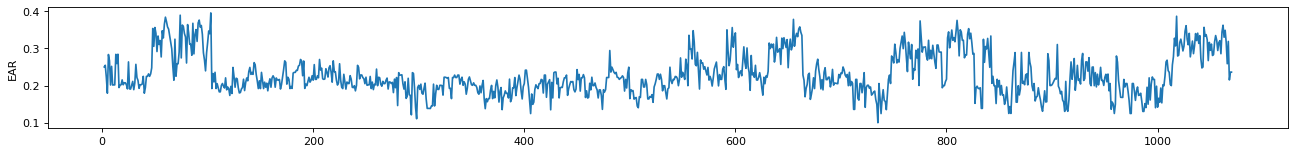

In [36]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(frameArray,EARArray)
plt.ylabel('EAR')

plt.show()